<a href="https://colab.research.google.com/github/Dnyanada-Nimbalkar/NLP/blob/main/Chatbot_with_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Question and Answer Chat Bots

In [2]:
import pickle
import numpy as np

In [3]:
with open('train_qa.txt','rb') as f:
  train_data=pickle.load(f)

In [4]:
with open('test_qa.txt','rb') as f:
  test_data=pickle.load(f)

In [5]:
all_data = train_data + test_data

-----

## Setting up Vocabulary of All Words

In [6]:
vocab=set()

for story,question,answer in all_data:
  vocab=vocab.union(set(story))
  vocab=vocab.union(set(question))


In [7]:
vocab.add('no')
vocab.add('yes')

In [8]:
vocab_len=len(vocab) + 1

In [9]:
all_story_lens=[len(data[0]) for data in all_data]

In [10]:
max_story_len=max(all_story_lens)

In [11]:
max_question_len=max([len(data[1]) for data in all_data])

In [12]:
max_question_len

6

In [15]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.5 MB/s eta 0:00:00


In [19]:
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [20]:
tokenizer=Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [21]:
tokenizer.word_index

{'got': 1,
 'is': 2,
 'back': 3,
 'there': 4,
 'left': 5,
 'journeyed': 6,
 'milk': 7,
 'up': 8,
 'bedroom': 9,
 'mary': 10,
 'dropped': 11,
 'sandra': 12,
 'put': 13,
 'in': 14,
 'office': 15,
 'discarded': 16,
 'grabbed': 17,
 'moved': 18,
 'took': 19,
 'to': 20,
 'garden': 21,
 'no': 22,
 'kitchen': 23,
 'picked': 24,
 'hallway': 25,
 'john': 26,
 '?': 27,
 'daniel': 28,
 'football': 29,
 'travelled': 30,
 'apple': 31,
 'yes': 32,
 'went': 33,
 '.': 34,
 'the': 35,
 'down': 36,
 'bathroom': 37}

In [22]:
train_story_texts=[]
train_question_tests=[]
train_answers=[]

In [23]:
for story,question,answer in train_data:
  train_story_texts.append(story)
  train_question_tests.append(question)
  train_answers.append(answer)

In [24]:
train_story_seq=tokenizer.texts_to_sequences(train_story_texts)

### Functionalize Vectorization

In [25]:
def vectorize_stories(data,word_index=tokenizer.word_index,max_story_len=max_story_len,max_question_len=max_question_len):

  # stories
  X=[]
  #questions
  Xq=[]
  #answers
  Y=[]

  for story,question,answer in data:
    x=[word_index[word.lower()] for word in story]
    xq=[word_index[word.lower()] for word in question]
    y=np.zeros(len(word_index)+1)
    y[word_index[answer]]=1
    X.append(x)
    Xq.append(xq)
    Y.append(y)

  return (pad_sequences(X,maxlen=max_story_len),pad_sequences(Xq,maxlen=max_question_len),np.array(Y))

In [27]:
inputs_train,queries_train,answers_train = vectorize_stories(train_data)

In [26]:
inputs_test,queries_test,answers_test = vectorize_stories(test_data)

## Creating the Model

In [29]:
from keras.models import Sequential, Model

In [31]:
from keras.layers import Embedding

In [42]:
from keras.layers import LSTM, Dense , Activation, Input , Permute, Dropout,add, dot, concatenate

In [33]:
input_sequence=Input((max_story_len,))
question=Input((max_question_len,))

In [34]:
vocab_size=len(vocab)+1

## Encoders

### Input Encoder m

In [37]:
#input_encoder_m
input_encoder_m=Sequential()

input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

#Output
#(samples,story_maxlen,embedding_dim)

In [38]:
#input_encoder_c
input_encoder_c=Sequential()

input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

#Output
#(samples,story_maxlen,max_question_len)

In [39]:
question_encoder=Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,output_dim=64,input_length=max_question_len))
question_encoder.add(Dropout(0.3))

#(samples,query_maxlen,embedding_dim)

In [46]:
#encoded <---- Encoder(input)
input_encoded_m=input_encoder_m(input_sequence)
input_encoded_c=input_encoder_c(input_sequence)
question_encoded=question_encoder(question)

In [47]:
match=dot([input_encoded_m,question_encoded],axes=(2,2))
match=Activation('softmax')(match)

In [48]:
response=add([match,input_encoded_c])
response=Permute((2,1))(response)

In [49]:
answer=concatenate([response,question_encoded])

In [50]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

In [51]:
answer=LSTM(32)(answer)

In [52]:
answer=Dropout(0.5)(answer)
answer=Dense(vocab_size)(answer)  #(samples,vocab_size) #Yes/No

In [53]:
answer= Activation('softmax')(answer)

In [54]:
model=Model([input_sequence,question],answer)

In [60]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [61]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, None, 64)     2432        ['input_1[0][0]']                
                                                                                                  
 sequential_4 (Sequential)      (None, 6, 64)        2432        ['input_2[0][0]']                
                                                                                              

In [62]:
history=model.fit([inputs_train,queries_train],answers_train,batch_size=32,epochs=3,validation_data=([inputs_test,queries_test],answers_test))

Epoch 1/3
313/313 [==============================] - 11s 22ms/step - loss: 0.9338 - accuracy: 0.4989 - val_loss: 0.6967 - val_accuracy: 0.5030
Epoch 2/3
313/313 [==============================] - 7s 22ms/step - loss: 0.7095 - accuracy: 0.5036 - val_loss: 0.6968 - val_accuracy: 0.5030
Epoch 3/3
313/313 [==============================] - 7s 22ms/step - loss: 0.6996 - accuracy: 0.4952 - val_loss: 0.6933 - val_accuracy: 0.4940


In [63]:
filename = 'chatbot_120_epochs.h5'
model.save(filename)

In [68]:
history.history.items()

dict_items([('loss', [0.9338088631629944, 0.7094628214836121, 0.6996129155158997]), ('accuracy', [0.49889999628067017, 0.503600001335144, 0.4952000081539154]), ('val_loss', [0.6966920495033264, 0.6967592835426331, 0.6933035850524902]), ('val_accuracy', [0.503000020980835, 0.503000020980835, 0.49399998784065247])])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


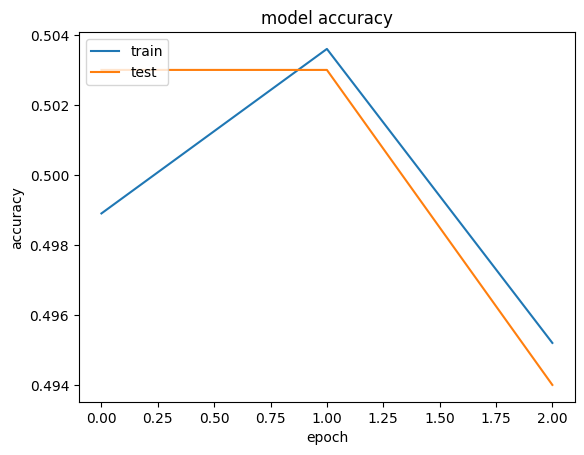

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [70]:
# train
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=120,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/120
313/313 [==============================] - 7s 22ms/step - loss: 0.6965 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.4900
Epoch 2/120
313/313 [==============================] - 6s 20ms/step - loss: 0.6959 - accuracy: 0.5041 - val_loss: 0.6938 - val_accuracy: 0.5030
Epoch 3/120
313/313 [==============================] - 7s 22ms/step - loss: 0.6964 - accuracy: 0.4947 - val_loss: 0.6934 - val_accuracy: 0.5030
Epoch 4/120
313/313 [==============================] - 6s 18ms/step - loss: 0.6951 - accuracy: 0.5068 - val_loss: 0.6935 - val_accuracy: 0.4970
Epoch 5/120
313/313 [==============================] - 7s 22ms/step - loss: 0.6952 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 6/120
313/313 [==============================] - 6s 18ms/step - loss: 0.6953 - accuracy: 0.4998 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 7/120
313/313 [==============================] - 7s 22ms/step - loss: 0.6955 - accuracy: 0.4987 - val_loss: 0.6946 - val_accuracy:

## Evaluating the Model

### Plotting Out Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


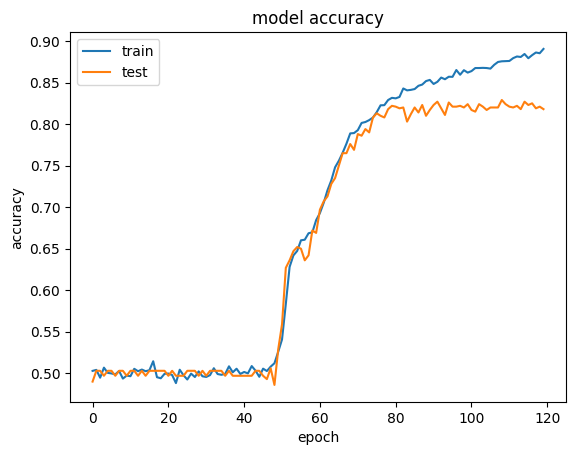

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluating on Given Test Set

In [73]:
model.load_weights(filename)
pred_results = model.predict(([inputs_test, queries_test]))

32/32 [==============================] - 1s 5ms/step


In [74]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [75]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [76]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [77]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  yes
Probability of certainty was:  0.500473


## Writing Your Own Stories and Questions

Remember you can only use words from the existing vocab

In [78]:
# Note the whitespace of the periods
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [79]:
my_question = "Is the football in the garden ?"

In [80]:
mydata = [(my_story.split(),my_question.split(),'yes')]

In [81]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [82]:
pred_results = model.predict(([ my_story, my_ques]))

1/1 [==============================] - 0s 27ms/step


In [83]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.49994135
